# Setup

In [1]:
# Third-party imports
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import plotly.graph_objects as go
import plotly.express as px
import getpass

# Local packages
from database import connect
import queries
import plots
from params import categorical_cols, date_cols, col_names, plot_params_dict

## Connecting to an SQL database with Python

In [2]:
# Log into the database
username = 'analysisedwardpearce'  # input('username:')
db = connect(username, getpass.getpass('password:'))

password:········


In [3]:
pop_queries = {'sim1': '''SELECT * FROM analysispaulclarke.sim_av_tumour_final''',
               'sim2': '''SELECT * FROM analysispaulclarke.SIM_AV_TUMOUR_SIMII''',
               'av2015': queries.AV2015_pop_query.replace('\n', ' '),
               'av2017': queries.AV2017_pop_query.replace('\n', ' ')}

## Working locally

In [2]:
key_list = ['sim1', 'sim2', 'av2015', 'av2017']
comparison_pairs = [('sim1', 'av2015'), ('sim2', 'av2017')]

In [3]:
univariate_filepath = r"results\{}_univariate_counts.csv"
bivariate_filepath_categorical = r"results\{}_bivariate_counts_categorical.csv"
bivariate_filepath_double_dates = r"results\{}_bivariate_counts_double_dates.csv"
bivariate_filepath_diagnosis_dates = r"results\{}_bivariate_counts_diagnosis_dates.csv"
bivariate_filepath_surgery_dates = r"results\{}_bivariate_counts_surgery_dates.csv"

univariate_filepaths = {key: univariate_filepath.format(key.upper()) for key in key_list}
bivariate_filepaths_categorical = {key: bivariate_filepath_categorical.format(key.upper()) for key in key_list}
bivariate_filepaths_double_dates = {key: bivariate_filepath_double_dates.format(key.upper()) for key in key_list}
bivariate_filepaths_diagnosis_dates = {key: bivariate_filepath_diagnosis_dates.format(key.upper()) for key in key_list}
bivariate_filepaths_surgery_dates = {key: bivariate_filepath_surgery_dates.format(key.upper()) for key in key_list}

### Writing

In [5]:
# from write_results import write_counts_to_csv

# for key, pop_query in pop_queries.items():
#     write_counts_to_csv(pop_query, db, key, filepaths[key])

# This takes some time (10s of minutes) and could possibly be sped up by splitting into chunks for preprocessing
# for key, pop_query in pop_queries.items():
#     write_counts_to_csv(pop_query, db, key, filepaths2[key], num_variates=2)

Getting the data - calculating counts in SQL...
Totals pulled from database successfully! (1535722 rows, 5 columns)
Cleaning category names and sorting...
Data cleaned and sorted!
Saving the results at results\AV2015_bivariate_counts.csv
Saved! Function complete!
Getting the data - calculating counts in SQL...
Totals pulled from database successfully! (2466850 rows, 5 columns)
Cleaning category names and sorting...
Data cleaned and sorted!
Saving the results at results\AV2017_bivariate_counts.csv
Saved! Function complete!


### Reading

#### Univariate group counts

In [4]:
counts_tables = {key: pd.read_csv(filepath, usecols=[0, 3, 2], 
                                  dtype={'column_name': 'category', 'counts_'+key: 'uint32'}) 
                 for key, filepath in univariate_filepaths.items()}
for key, frame in counts_tables.items():
    print(key, frame.shape)

sim1 (4178, 3)
sim2 (5792, 3)
av2015 (4040, 3)
av2017 (5636, 3)


In [5]:
pop_sizes = {'sim1': 1402817, 'av2015': 1462158, 'sim2': 2371686, 'av2017': 2483089}
for key, value in pop_sizes.items():
    check = (counts_tables[key].groupby(by='column_name').sum() == value).all().iloc[0]
    print('The number of data entries in the {} cohort is {}:'.format(key, value), check)

The number of data entries in the sim1 cohort is 1402817: True
The number of data entries in the av2015 cohort is 1462158: True
The number of data entries in the sim2 cohort is 2371686: True
The number of data entries in the av2017 cohort is 2483089: True


#### Bivariate group counts

In [8]:
bivariate_counts_tables_categorical = {key: pd.read_csv(filepath,
                                                        dtype={'column_name1': 'category', 'column_name2': 'category', 'paired_counts_'+key: 'uint32'}) 
                                       for key, filepath in bivariate_filepaths_categorical.items()}
for key, frame in bivariate_counts_tables_categorical.items():
    print(key, frame.shape)

sim1 (239224, 5)
sim2 (271485, 5)
av2015 (203454, 5)
av2017 (226221, 5)


In [9]:
bivariate_counts_tables_diagnosis_dates = {key: pd.read_csv(filepath, usecols=[1, 2, 3, 4], 
                                                            parse_dates={'DIAGNOSISDATEBEST': [1]},
                                                            infer_datetime_format=True,
                                                  dtype={'column_name2': 'category', 'paired_counts_'+key: 'uint32'}) 
                                 for key, filepath in bivariate_filepaths_diagnosis_dates.items()}
bivariate_counts_tables_surgery_dates = {key: pd.read_csv(filepath, usecols=[1, 2, 3, 4], 
                                                          parse_dates={'DATE_FIRST_SURGERY': [1]},
                                                          infer_datetime_format=True,
                                                  dtype={'column_name2': 'category', 'paired_counts_'+key: 'uint32'}) 
                                 for key, filepath in bivariate_filepaths_surgery_dates.items()}
bivariate_counts_tables_double_dates = {key: pd.read_csv(filepath, usecols=[2, 3, 4], 
                                                         parse_dates={'DATE_FIRST_SURGERY': [0], 'DIAGNOSISDATEBEST': [1]},
                                                         infer_datetime_format=True,
                                                  dtype={'paired_counts_'+key: 'uint32'}) 
                                 for key, filepath in bivariate_filepaths_double_dates.items()}

C:\Users\edward.pearce\AppData\Local\Continuum\miniconda3\envs\idp\lib\site-packages\IPython\core\interactiveshell.py:3248: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# Joining the tables of counts

## Joining directly in SQL

In [ ]:
totals_comb = pd.read_sql_query(queries.all_counts_query(sim1_pop_query, AV2015_pop_query), db)
print(totals_comb.shape)

In [ ]:
totals_comb2 = pd.read_sql_query(queries.all_counts_query(sim2_pop_query, AV2017_pop_query), db)
print(totals_comb2.shape)

In [ ]:
totals_comb.head(10)

In [ ]:
totals_comb2.head(10)

### Preliminary checks

Some cases of particular interest may include:
- Simulated values which are not present in the real dataset (although we typically wouldn't worry about this in the case of datetime fields). Such values could not have been sampled from the real data, and statistical tests cannot be meaningfully carried out on these values since they are not expected to occur at all based on the real data.
- Real values which are not present in the simulated dataset. Sometimes this can be explained as reasonable if the values are themselves rare in the real data, however this can also help to identify values which are being significantly underrepresented in the simulated data.

In [ ]:
totals_comb.loc[totals_comb.counts_r == 0].tail(10)

In [ ]:
totals_comb.loc[(totals_comb.counts_s == 0) & (totals_comb.counts_r >= 10)]

In [ ]:
interact(lambda col_name: plots.view_by_field(totals_comb, col_name), col_name=col_names);

## Using Python's Pandas package

In [6]:
def join_counts(table1, table2, count_cols):
    joined = pd.merge(table1, table2, on=['column_name', 'val_clean'], how='outer')[['column_name', 'val_clean'] + count_cols]
    joined[count_cols] = joined[count_cols].fillna(0, axis=1)
    return joined

def check_zeros(table, ignore=['DATE_FIRST_SURGERY', 'DIAGNOSISDATEBEST']):
    check = (table == 0).any(axis=1)
    for field in ignore:
        check = check & (table.column_name != field)
    return table.loc[check]

In [7]:
comparison1 = join_counts(counts_tables['av2015'], counts_tables['sim1'], count_cols=['counts_av2015', 'counts_sim1'])
comparison2 = join_counts(counts_tables['av2017'], counts_tables['sim2'], count_cols=['counts_av2017', 'counts_sim2'])
all_joined = join_counts(comparison1, comparison2, count_cols=['counts_av2015', 'counts_sim1', 'counts_av2017', 'counts_sim2'])

In [8]:
check_zeros(all_joined, ignore=['DATE_FIRST_SURGERY', 'DIAGNOSISDATEBEST'])

,column_name,val_clean,counts_av2015,counts_sim1,counts_av2017,counts_sim2
4,GRADE,G5,1.0,0.0,1.0,3.0
102,AGE,94,5596.0,0.0,9648.0,9330.0
103,AGE,95,3693.0,0.0,6832.0,6368.0
104,AGE,96,2208.0,0.0,4587.0,4361.0
105,AGE,97,1574.0,0.0,2902.0,2851.0
106,AGE,98,1200.0,0.0,1920.0,1814.0
107,AGE,99,798.0,0.0,1239.0,1200.0
114,AGE,106,5.0,0.0,12.0,0.0
115,AGE,107,4.0,0.0,10.0,0.0
116,AGE,108,4.0,0.0,5.0,0.0


# Augmenting the table of totals (Theory)

We will add the following columns to our table to further analyse and compare the real and simulated datasets:
- The fraction/proportion of all entries in the corresponding table which take on a given value
- A normal approximation to a binomial test statistic, and a flag for whether the normal approximation is appropriate (further details below)

In [9]:
for key, pop_size in pop_sizes.items():
    all_joined['counts_'+key] = all_joined['counts_'+key].astype('uint32')
    all_joined['proportion_'+key] = all_joined['counts_'+key]/pop_size
for pair in comparison_pairs:
    suffix = pair[0] + '_' + pair[1]
    all_joined['p_diff_'+suffix] = all_joined['proportion_'+pair[0]] - all_joined['proportion_'+pair[1]]
    all_joined['p_ave_'+suffix] = (all_joined['counts_'+pair[0]] + all_joined['counts_'+pair[1]]) / (pop_sizes[pair[0]] + pop_sizes[pair[1]])
    all_joined['z_test_'+suffix] = all_joined['p_diff_'+suffix]/np.sqrt(all_joined['p_ave_'+suffix] * (1 - all_joined['p_ave_'+suffix]) * ((1/pop_sizes[pair[0]]) + (1/pop_sizes[pair[1]])))
    all_joined['expected_count_'+pair[0]] = pop_sizes[pair[0]] * all_joined['proportion_'+pair[1]]

In [10]:
all_joined.loc[all_joined.column_name == 'SCREENINGSTATUSFULL_CODE']

,column_name,val_clean,counts_av2015,counts_sim1,counts_av2017,counts_sim2,proportion_sim1,proportion_av2015,proportion_sim2,proportion_av2017,p_diff_sim1_av2015,p_ave_sim1_av2015,z_test_sim1_av2015,expected_count_sim1,p_diff_sim2_av2017,p_ave_sim2_av2017,z_test_sim2_av2017,expected_count_sim2
133,SCREENINGSTATUSFULL_CODE,1,57,59,108,100,4.205823e-05,3.898348e-05,4.216410e-05,4.349421e-05,3.074755e-06,4.048901e-05,0.408873,5.468668e+01,-1.330115e-06,4.284442e-05,-0.223816,1.031546e+02
134,SCREENINGSTATUSFULL_CODE,3,1,0,1,4,0.000000e+00,6.839206e-07,1.686564e-06,4.027242e-07,-6.839206e-07,3.490432e-07,-0.979498,9.594155e-01,1.283840e-06,1.029914e-06,1.393320,9.551353e-01
135,SCREENINGSTATUSFULL_CODE,5001,817,831,2788,2845,5.923795e-04,5.587631e-04,1.199569e-03,1.122795e-03,3.361633e-05,5.752232e-04,1.186299,7.838424e+02,7.677354e-05,1.160301e-03,2.483811,2.662917e+03
136,SCREENINGSTATUSFULL_CODE,5002,49,44,51,49,3.136546e-05,3.351211e-05,2.066041e-05,2.053893e-05,-2.146651e-06,3.246102e-05,-0.318805,4.701136e+01,1.214743e-07,2.059828e-05,0.029479,4.871190e+01
137,SCREENINGSTATUSFULL_CODE,5003,2,2,2,4,1.425703e-06,1.367841e-06,1.686564e-06,8.054484e-07,5.786148e-08,1.396173e-06,0.041434,1.918831e+00,8.811155e-07,1.235897e-06,0.872936,1.910271e+00
138,SCREENINGSTATUSFULL_CODE,5005,38,33,187,179,2.352409e-05,2.598898e-05,7.547373e-05,7.530942e-05,-2.464889e-06,2.478207e-05,-0.418959,3.645779e+01,1.643117e-07,7.538969e-05,0.020843,1.786103e+02
139,SCREENINGSTATUSFULL_CODE,5006,54,45,222,236,3.207831e-05,3.693171e-05,9.950727e-05,8.940477e-05,-4.853402e-06,3.455528e-05,-0.698608,5.180844e+01,1.010250e-05,9.434011e-05,1.145622,2.120400e+02
140,SCREENINGSTATUSFULL_CODE,5008,171,180,439,445,1.283132e-04,1.169504e-04,1.876302e-04,1.767959e-04,1.136282e-05,1.225142e-04,0.868674,1.640600e+02,1.083432e-05,1.820888e-04,0.884382,4.193044e+02
141,SCREENINGSTATUSFULL_CODE,5009,544,540,1381,1373,3.849397e-04,3.720528e-04,5.789131e-04,5.561621e-04,1.288692e-05,3.783628e-04,0.560679,5.219220e+02,2.275096e-05,5.672765e-04,1.052363,1.319042e+03
142,SCREENINGSTATUSFULL_CODE,5011,336,358,983,1096,2.552008e-04,2.297973e-04,4.621185e-04,3.958779e-04,2.540346e-05,2.422360e-04,1.381222,3.223636e+02,6.624063e-05,4.282382e-04,3.526265,9.388980e+02


## Binomial test for each category in each field

### One-sample z-test with binomial assumption

For each category in each column of the simulated `AV_TUMOUR` table (2013-2015 England finalised cohort) we will test the null hypothesis 

$$H_0: X_{C}\sim\mathrm{Bin}(n,\hat{p}_{C})=\mathrm{Bin}(1,402,817,E_{C}/1,478,425)$$ 

that the occurrence $X_{C}$ of category $C$ in the simulated tumour dataset was sampled from a binomial distribution $\mathrm{Bin}(n,\hat{p}_{C})$ where $n=1,402,817$ is the number of simulated tumour entries/rows and $\hat{p}_{C}$ is the proportion of the $1,478,425$ real tumour entries which fall into category $C$, against the alternative hypothesis that the simulated dataset was sampled in some other way (e.g. $X$ binomially distributed with a different value of p; $X$ not binomially distributed (e.g. p not constant between trials or trials not independent, etc), etc.). 

If n is large enough, then the skew of the Binomial distribution is not too great. In this case a reasonable approximation to $B(n, p)$ is given by the normal distribution $\mathcal{N}(np,np(1-p))$. - [Wikipedia](https://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation)

In this case we may use the test statistic 

$$z = \frac{X - np}{\sqrt{np(1-p)}}\sim\mathcal{N}(0,1)$$

#### When is the normal approximation appropriate?

The code below draws a graph to illustrate how the continous normal distribution approximates the discrete binomial distribution. The vertical lines show the probability mass functions of different binomial distributions whilst the smooth black lines show the probability distribution functions of their corresponding approximating normal distributions, which are based on the mean and variances of their respective binomial distibution.

In [ ]:
import numpy as np
from scipy.stats import binom, norm
fig, ax = plt.subplots(1, 1, figsize=(15,10))

n = 40
colors = ['b', 'y', 'r']
probs = [0.7, 0.9, 0.99]
binom_dists = [binom(n, p) for p in probs]
moments = [drv.stats(moments='mv') for drv in binom_dists]
norm_dists = [norm(loc=mv[0], scale=np.sqrt(mv[1])) for mv in moments]

x = np.arange(20, 41)
#x = [np.arange(drv.ppf(0.005), drv.ppf(0.995)) for drv in binom_dists]
x1 = [np.linspace(crv.ppf(0.005), crv.ppf(0.995), 100) for crv in norm_dists]

for i in range(len(probs)):
    ax.vlines(x, 0, binom_dists[i].pmf(x), color=colors[i], label='p = {} and n = {}'.format(probs[i], n))
    ax.plot(x1[i], norm_dists[i].pdf(x1[i]), 'k')
ax.set_xlabel('$x$', fontsize = 24) 
ax.set_ylabel('$P(X=x)$', fontsize = 24) 
ax.set_title('Binomial distributions and their Normal approximations', fontsize = 24) 
ax.legend()

Notice that the as the success probability $p$ gets closer to $0$ or $1$, the binomial distribution gets more skewed/less symmetric, and matches up less well with its normal approximation (which is always symmetric about its mean value). In these extreme cases, the normal approximation also assigns nontrivial probabilities to impossible events under the binomial setup (i.e. more success than trials, or negative number of successes). 

For these reasons, using the z-test statistic in these cases may lead to misleading results, namely an increased number of Type I errors - rejecting a true null hypothesis, which in our case means identifying more simulated categories as failing to closely match their real counterparts than is truely the case.

Therefore we apply the rule which states that the normal approximation is appropriate only if everything within 3 standard deviations of its mean is within the range of possible values; that is, only if

$$\mu \pm 3\sigma =np\pm 3{\sqrt {np(1-p)}}\in (0,n)$$

This 3-standard-deviation rule is equivalent to the following conditions:

$$n>9\left({\frac {1-p}{p}}\right)\quad {\text{and}}\quad n>9\left({\frac {p}{1-p}}\right)$$

We may wish to check the feasibility of calculating the exact binomial test statistics using SciPy in some cases
`scipy.stats.binom_test(51, 235, 1.0/6, alternative='two-sided')`

### Pooled two-sample z-test with binomial assumption

See the explanation [here](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/PASS/Tests_for_Two_Proportions.pdf)

This tests the null hypothesis that 

Test statistic:

$$z = \frac{\hat{p}_{1} - \hat{p}_{2}}{\sqrt{\hat{p}(1 - \hat{p})(\frac{1}{n_{1}} + \frac{1}{n_{2}})}}\sim\mathcal{N}(0,1)$$

where 

$$\hat{p} = \frac{X_{1} + X_{2}}{n_{1} + n_{2}}$$

This test has the advantage of still being calculable in the case that $\hat{p}_{C}=0$ due to zero occurences of a particular value/category in the real data, which might reasonably occur in the case of date fields and some fields relating to rare cancers. The previous one-sample z-test would produce an infinite test statistic when $X\ne0$ due to dividing by zero, which indicates an expected number of entries in the given category being exactly 0 with absolute certainty.

## Pearson's chi-squared test and Likelihood-ratio/G-test for each field

You can read the Wikipedia pages for background on the various kinds of [multinomial test](https://en.wikipedia.org/wiki/Multinomial_test), namely:
- [Pearson's chi-squared test](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
![Pearson's chi-squared test](https://wikimedia.org/api/rest_v1/media/math/render/svg/c4fd8945d1bdd2aa3cc133571cb8bb0b232fac3b)
- [Likelihood-ratio test](https://en.wikipedia.org/wiki/Likelihood-ratio_test) (a.k.a. [G-test](https://en.wikipedia.org/wiki/G-test))
![G-test](https://wikimedia.org/api/rest_v1/media/math/render/svg/fefb45c7ddf75da6452e9bfdcb17925d1b690552)

It is necessary to calculate the test statistics based on proportions since the size of the real and simulated datasets are not equal. Number of degrees of freedom equal to number of categories minus 1?

# Test results: Pandas implementation + Plotly

In [24]:
def colour_mask(series, true_colour, false_colour):
    return series.apply(lambda value: true_colour if value else false_colour)

In [41]:
def univariate_results(col_name):
    plotting_df = all_joined.loc[all_joined.column_name == col_name]
    fig = go.Figure(data=[
        go.Bar(name='Sim1 vs. AV2015', x=plotting_df.val_clean, y=plotting_df.z_test_sim1_av2015,
              marker_color=colour_mask(plotting_df.z_test_sim1_av2015.abs() < 2, 'darkblue', 'darkred')),
        go.Bar(name='Sim2 vs. AV2017', x=plotting_df.val_clean, y=plotting_df.z_test_sim2_av2017,
              marker_color=colour_mask(plotting_df.z_test_sim2_av2017.abs() < 2, 'blue', 'red'))
    ])
    # Change the bar mode
    if col_name in categorical_cols and col_name != 'AGE':
        fig.update_layout(xaxis={'type': 'category', 'categoryorder':'category ascending'})
    fig.update_layout(barmode='group')
    fig.show()

In [42]:
interact(univariate_results, col_name=col_names)

interactive(children=(Dropdown(description='col_name', options=('GRADE', 'AGE', 'SEX', 'CREG_CODE', 'SCREENING…

<function __main__.univariate_results(col_name)>

# Test results: SQL implementation + matplotlib

## Table and plots - Sim1 vs. AV2015 cohort

In [15]:
analysis_df = pd.read_sql_query(queries.compute_stats_query(pop_queries['sim1'], pop_queries['av2015']), db)
analysis_df.shape

(4254, 14)

In [16]:
interact(lambda col_name: plots.view_by_field(analysis_df, col_name), col_name=col_names);

interactive(children=(Dropdown(description='col_name', options=('GRADE', 'AGE', 'SEX', 'CREG_CODE', 'SCREENING…

In [17]:
interact(lambda col_name, plot_type: plots.plot_by_category(analysis_df, col_name, plot_type), 
         col_name=col_names, plot_type=plot_params_dict.keys());

interactive(children=(Dropdown(description='col_name', options=('GRADE', 'AGE', 'SEX', 'CREG_CODE', 'SCREENING…

## Results: Table and plots - Sim2 vs. AV2017 cohort

In [21]:
analysis_df2 = pd.read_sql_query(queries.compute_stats_query(pop_queries['sim2'], pop_queries['av2017']), db)
analysis_df2.shape

(5880, 14)

In [22]:
interact(lambda col_name: plots.view_by_field(analysis_df2, col_name), col_name=col_names);

interactive(children=(Dropdown(description='col_name', options=('GRADE', 'AGE', 'SEX', 'CREG_CODE', 'SCREENING…

In [23]:
interact(lambda col_name, plot_type: plots.plot_by_category(analysis_df2, col_name, plot_type), 
         col_name=col_names, plot_type=plot_params_dict.keys());

interactive(children=(Dropdown(description='col_name', options=('GRADE', 'AGE', 'SEX', 'CREG_CODE', 'SCREENING…

# Evaluating the test results

In [ ]:
analysis_df.iloc[:,2:].abs().describe()

In [ ]:
analysis_df[['binom_z_test_one_sample', 'z_test_two_sample_pooled']].describe()

In [ ]:
analysis_df[['binom_z_test_one_sample', 'z_test_two_sample_pooled']].plot.box(vert=False, figsize=(15, 6))

In [ ]:
import numpy as np
from scipy.stats import norm
fig, axes = plt.subplots(2,1, figsize=(15,10))

# First plot standard normal distributions on both axes for reference
x = np.linspace(norm.ppf(0.0001), norm.ppf(0.9999), 100)
for ax in axes:
    ax.plot(x, norm.pdf(x), 'k')
# Now plot the histograms of test-statistic values
analysis_df[['binom_z_test_one_sample']].hist(bins=2500, density=True, ax=axes[0])
analysis_df[['z_test_two_sample_pooled']].hist(bins=2500, density=True, ax=axes[1])
# Set the limits for the x-axis
axes[0].set_xlim(-7,7);
axes[0].set_title('Histogram of one-sample z-test statistics over all categories in all fields', fontsize = 24);
axes[1].set_xlim(-7,7);
axes[1].set_title('Histogram of two-sample z-test statistics over all categories in all fields', fontsize = 24);

In [ ]:
import numpy as np
from scipy.stats import norm
fig, axes = plt.subplots(2,1, figsize=(15,10))

# First plot standard normal distributions on both axes for reference
x = np.linspace(norm.ppf(0.0001), norm.ppf(0.9999), 100)
for ax in axes:
    ax.plot(x, norm.pdf(x), 'k')
# Now plot the histograms of test-statistic values
analysis_df2[['binom_z_test_one_sample']].hist(bins=2500, density=True, ax=axes[0])
analysis_df2[['z_test_two_sample_pooled']].hist(bins=2500, density=True, ax=axes[1])
# Set the limits for the x-axis
axes[0].set_xlim(-7,7);
axes[0].set_title('Histogram of one-sample z-test statistics over all categories in all fields', fontsize = 24);
axes[1].set_xlim(-7,7);
axes[1].set_title('Histogram of two-sample z-test statistics over all categories in all fields', fontsize = 24);

In [ ]:
import numpy as np
from scipy.stats import norm
fig, ax = plt.subplots(1,1, figsize=(15,10))

# First plot standard normal distributions on both axes for reference
x = np.linspace(norm.ppf(0.0001), norm.ppf(0.9999), 100)
ax.plot(x, norm.pdf(x), 'k')
# Now plot the histograms of test-statistic values
analysis_df[['z_test_two_sample_pooled']].hist(bins=2500, density=True, ax=ax)
# Set the limits for the x-axis
ax.set_xlim(-7,7)
ax.set_title('Histogram of two-sample z-test statistics over all categories in all fields', fontsize = 24);

# Exporting plots and chi-squared calculations

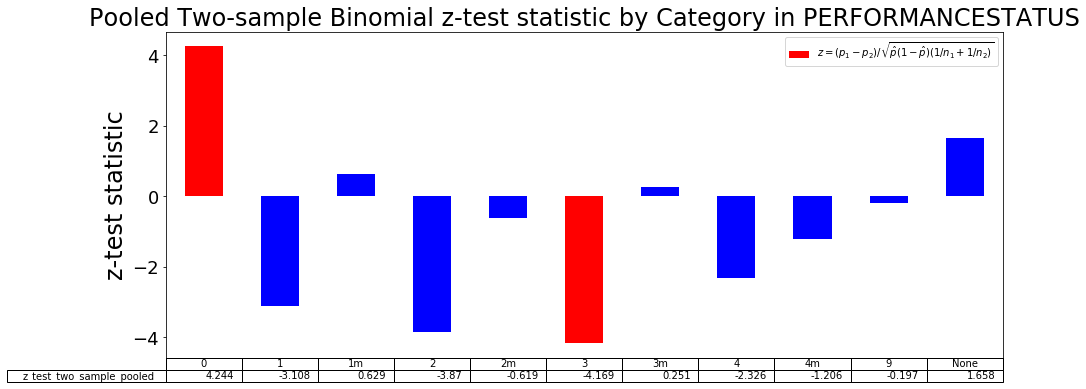

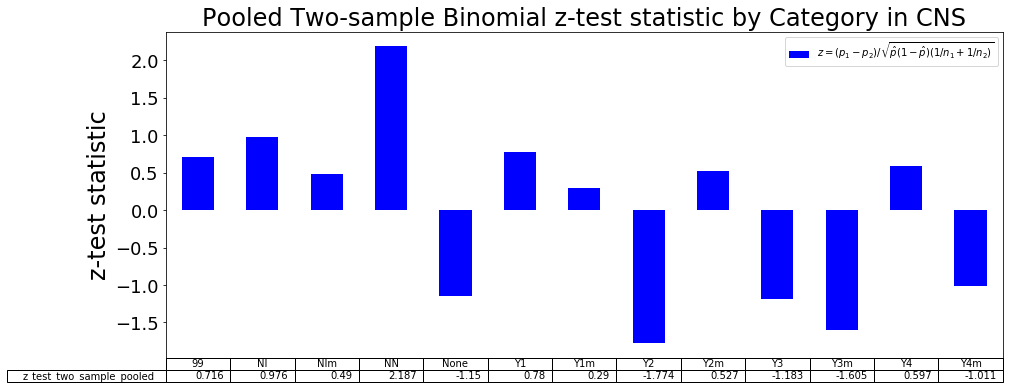

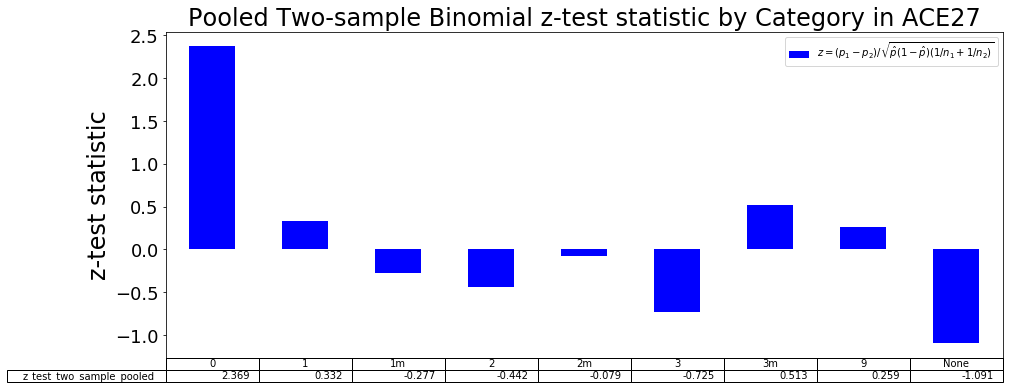

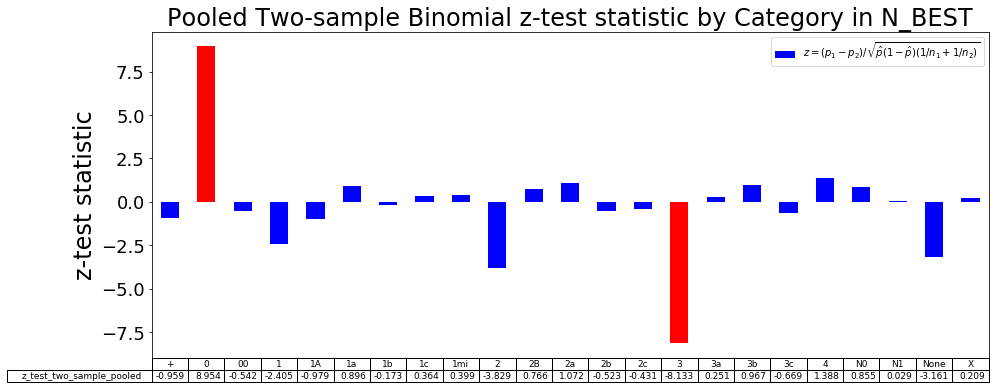

In [70]:
# variables = ['PERFORMANCESTATUS', 'CNS', 'ACE27', 'N_BEST']
# for variable in variables:
#     plots.plot_by_category(analysis_df, variable, 'Pooled Two-sample Binomial z-test')
#     plt.savefig("z_test_plot_{}.png".format(variable), transparent=False, dpi=300)

In [37]:
grouped.sum().head()

,counts_r,counts_s,proportion_r,proportion_s,abs_diff,rel_diff,average,binom_z_test_one_sample,one_sample_z_approx_valid,z_test_two_sample_pooled,pearson_summand,lr_summand
col_name,,,,,,,,,,,,
ACE27,1462158,1402817,1.0,1.0,4.743385e-20,0.022218,1.0,1.233873,9.0,0.858814,13.554903,6.735482
AGE,1462158,1402817,1.0,1.0,1.008075e-18,-11.012662,1.0,-135.066353,106.0,-181.999114,15242.733828,14857.562442
BEHAVIOUR_ICD10_O2,1462158,1402817,1.0,1.0,6.877908e-19,0.031250,1.0,-13.798443,9.0,-11.163564,959.527834,505.311745
CANCERCAREPLANINTENT,1462158,1402817,1.0,1.0,-6.776264e-20,-0.048580,1.0,-3.535114,7.0,-2.636607,140.828746,70.703030
CNS,1462158,1402817,1.0,1.0,4.065758e-20,-0.915154,1.0,0.401530,12.0,-0.160318,29.449044,15.456534


In [82]:
from scipy.stats import chisquare

analysis_df['f_exp'] = analysis_df.counts_r * (1402817/1462158)
chi2_tests = dict()
chi2_p_vals = dict()
for col_name in col_names:
    counts = analysis_df.loc[analysis_df.col_name == col_name]
    chi2_tests[col_name] = chisquare(counts['counts_s'], counts['f_exp'])[0]
    chi2_p_vals[col_name] = chisquare(counts['counts_s'], counts['f_exp'])[1]
results = pd.DataFrame([chi2_tests, chi2_p_vals]).T
results#.plot.bar(figsize=(15,10), ylim=(0, 0.01))

C:\Users\edward.pearce\AppData\Local\Continuum\miniconda3\envs\idp\lib\site-packages\scipy\stats\stats.py:4653: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


,0,1
ACE27,1.355490e+01,9.413012e-02
AGE,1.524273e+04,0.000000e+00
BEHAVIOUR_ICD10_O2,9.595278e+02,9.168614e-201
CANCERCAREPLANINTENT,1.408287e+02,6.699659e-28
CNS,2.944904e+01,3.377631e-03
CREG_CODE,6.536728e+01,1.268735e-11
DATE_FIRST_SURGERY,inf,0.000000e+00
DIAGNOSISDATEBEST,9.191540e+03,0.000000e+00
ER_SCORE,2.870176e+01,7.275074e-04
ER_STATUS,1.414253e+02,5.013345e-28


In [32]:
grouped = analysis_df.groupby(by='col_name')
results = pd.concat([grouped.size(), grouped['pearson_summand'].sum(), 2 * grouped['lr_summand'].sum(), grouped.size() - 1], axis=1)
results.columns = ['num_cats', 'Pearson_chi2_test', 'Likelihood_ratio_test', 'degrees_of_freedom']
results

,num_cats,Pearson_chi2_test,Likelihood_ratio_test,degrees_of_freedom
col_name,,,,
ACE27,9,13.554903,13.470964,8
AGE,114,15242.733828,29715.124883,113
BEHAVIOUR_ICD10_O2,10,959.527834,1010.623489,9
CANCERCAREPLANINTENT,7,140.828746,141.406060,6
CNS,13,29.449044,30.913068,12
CREG_CODE,8,65.367280,65.236566,7
DATE_FIRST_SURGERY,1593,460102.217677,182859.468498,1592
DIAGNOSISDATEBEST,1095,9191.539604,8136.314173,1094
ER_SCORE,10,28.701757,28.472210,9


In [6]:
# def myfunc(col_name):
#     return counts_tables['sim1'].loc[(counts_tables['sim1'].column_name == col_name)].plot.bar('val_clean', 'counts_sim1')
# interact(myfunc, col_name=col_names);

interactive(children=(Dropdown(description='col_name', options=('GRADE', 'AGE', 'SEX', 'CREG_CODE', 'SCREENING…